<a href="https://colab.research.google.com/github/paayala-rubio/Coffee-in-Canada/blob/main/Final%20Code%3A%20Sentiment_Analysis_and_Text_Mining_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Consumer Sentiment in Canada’s Coffee Scene: What Reviews Say About Tim Hortons and McCafé**

BAN 200: Sentiment Analysis and Text Mining

Submitted by: Moushita Mahmud, Paula Andrea Ayala Rubio, Sophanit Sin, Peter Fynn, Shatarupa Arjun Bachar

## **Import libraries**

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from math import log
from matplotlib.cm import get_cmap
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from math import sqrt
from collections import Counter
import random
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud

## **Data preparation**

After the data collection, perform data cleaning to create a dataset with the main features from each product, remove rows with empty reviews, and create a new column with the score in numeric format.

In [2]:
# Load both datasets for McCafé and Tim Hortons
Mc = pd.read_csv('reviews_data_Mc.csv')
Tim = pd.read_csv('reviews_data_Tim.csv')

In [3]:
# Add a new column to each dataset to identify the brand
Mc['Type'] = 'Mc Cafe'
Tim['Type'] = 'Tim Hortons'

In [4]:
# Combine both datasets
df = pd.concat([Mc, Tim], ignore_index=True)

In [5]:
# Add the score column to the dataset to extract the number of stars
df['Score'] = df['Stars'].str.extract(r'(\d+)').astype(int)

In [6]:
# Check data
df.head()

,Review_Date,User_Name,User_Type,Stars,Title,Details,Type,Score
0,"Dec 2, 2024",Biff Schmindle,Verified Purchase,5 out of 5 stars review,The best take-out coffee is available in my home,This is my favourite coffee when I buy it out ...,Mc Cafe,5
1,"Jan 23, 2025",Maren,Verified Purchase,5 out of 5 stars review,Keurig medium dark roast coffee pods order,Love this coffee (McCaf medium dark roast)! \n...,Mc Cafe,5
2,"May 14, 2025",Patricia Phibbs,Verified Purchase,5 out of 5 stars review,McD's the best!,"Yum! Love this coffee! It's rich and robust, a...",Mc Cafe,5
3,"May 16, 2025",I Anderson,Verified Purchase,5 out of 5 stars review,Bold,Bolder than the regular McCafe. One of the bet...,Mc Cafe,5
4,"May 2, 2025",Elon,Verified Purchase,5 out of 5 stars review,Delicious as always,Perfect coffee everytime. Tastes as expected a...,Mc Cafe,5


In [7]:
# Convert the data frame into a list of dictionaries
total_reviews=df.to_dict(orient='records')

In [8]:
# Filter the reviews where  Details (the review) is not empty and is a string
reviews = [
    review
    for review in total_reviews
    if isinstance(review.get('Details'), str) and review['Details'].strip() != ''
]

In [9]:
# Check data
reviews[0:3]

[{'Review_Date': 'Dec 2, 2024',
  'User_Name': 'Biff Schmindle',
  'User_Type': 'Verified Purchase',
  'Stars': '5 out of 5 stars review',
  'Title': 'The best take-out coffee is available in my home',
  'Details': "This is my favourite coffee when I buy it out of my home. I'm pleased to be able to get it without having to go out - then I can add my own creamers and sweeteners.\nI recommend this coffee to anyone who has a Keurig brewer",
  'Type': 'Mc Cafe',
  'Score': 5},
 {'Review_Date': 'Jan 23, 2025',
  'User_Name': 'Maren',
  'User_Type': 'Verified Purchase',
  'Stars': '5 out of 5 stars review',
  'Title': 'Keurig medium dark roast coffee pods order',
  'Details': "Love this coffee (McCaf medium dark roast)! \nIt is now so much easier to make a fresh cup of coffee each morning. Glad I ordered lots of these Keurig pods to have on hand so I don't run out. And the used pods are recyclable too!",
  'Type': 'Mc Cafe',
  'Score': 5},
 {'Review_Date': 'May 14, 2025',
  'User_Name': 'Pat

## **Data exploration**

Create charts to identify total reviews before and after removing missing values, total reviews by stars per brand and evolution by year according to the score (stars).

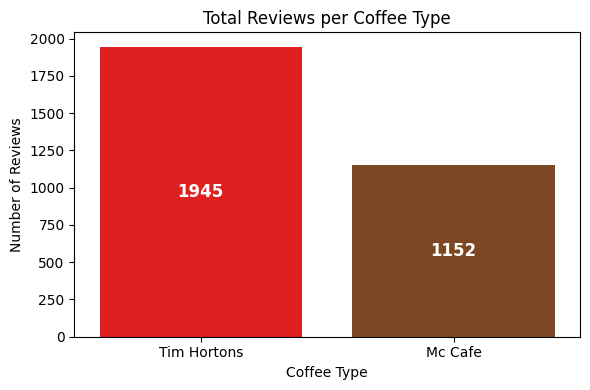

In [10]:
# Count of reviews per coffee type
type_counts = df['Type'].value_counts().reset_index()
type_counts.columns = ['Type', 'Count']

custom_palette = {
    'Tim Hortons': 'red',
    'Mc Cafe': 'saddlebrown',}

plt.figure(figsize=(6, 4))
ax = sns.barplot(data=type_counts, x='Type', y='Count', hue='Type', palette=custom_palette, legend=False)

for container in ax.containers:
    ax.bar_label(container, label_type='center', color='white', fontsize=12, weight='bold')

plt.title('Total Reviews per Coffee Type')
plt.ylabel('Number of Reviews')
plt.xlabel('Coffee Type')
plt.tight_layout()
plt.show()

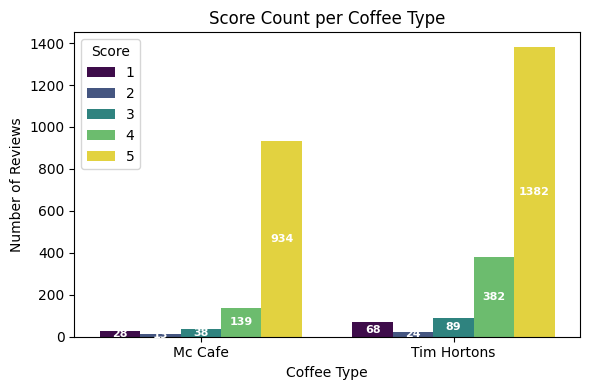

In [11]:
# Plot count of the score (stars)
score_counts = df.groupby(['Type', 'Score']).size().reset_index(name='Count')

plt.figure(figsize=(6, 4))
ax = sns.barplot(data=score_counts, x='Type', y='Count', hue='Score', palette='viridis')

for container in ax.containers:
    ax.bar_label(container, label_type='center', color='white', fontsize=8, weight='bold')

plt.title('Score Count per Coffee Type')
plt.ylabel('Number of Reviews')
plt.xlabel('Coffee Type')
plt.legend(title='Score')
plt.tight_layout()
plt.show()

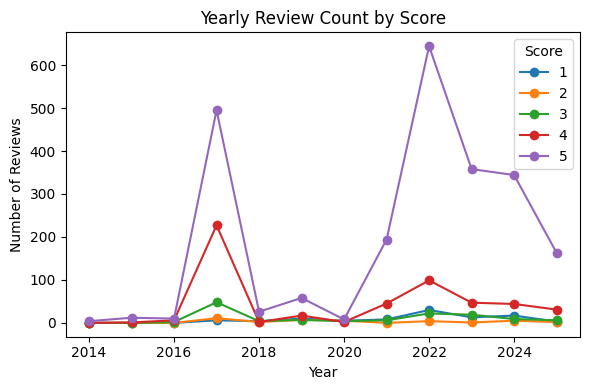

In [12]:
# Plot score count over time

# Convert Date to datetime format
df['Review_Date'] = pd.to_datetime(df['Review_Date'], errors='coerce')

# Extract Year
df['Year'] = df['Review_Date'].dt.year

# Group by Year and Score
yearly_counts = df.groupby(['Year', 'Score']).size().unstack(fill_value=0)

# Plot the chart
yearly_counts.plot(kind='line', marker='o', figsize=(6, 4))
plt.title('Yearly Review Count by Score')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.legend(title='Score')
plt.tight_layout()
plt.show()

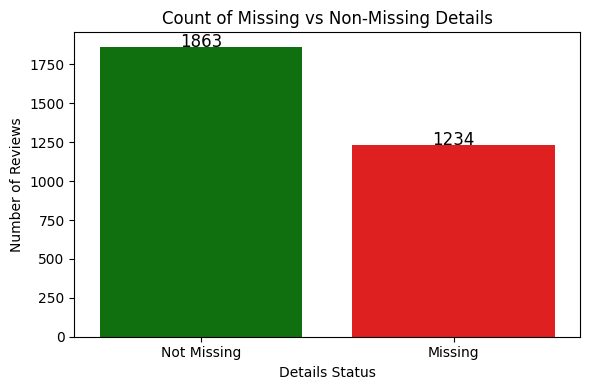

In [13]:
# Plot with missing reviews

missing = df['Details'].isna() | (df['Details'].str.strip() == '')
counts = missing.value_counts().rename(index={True: 'Missing', False: 'Not Missing'})

plt.figure(figsize=(6, 4))
sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette=['green', 'red'], legend=False)
plt.title('Count of Missing vs Non-Missing Details')
plt.ylabel('Number of Reviews')
plt.xlabel('Details Status')

ax = plt.gca()
for i, v in enumerate(counts.values):
    ax.text(i, v + 0.5, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

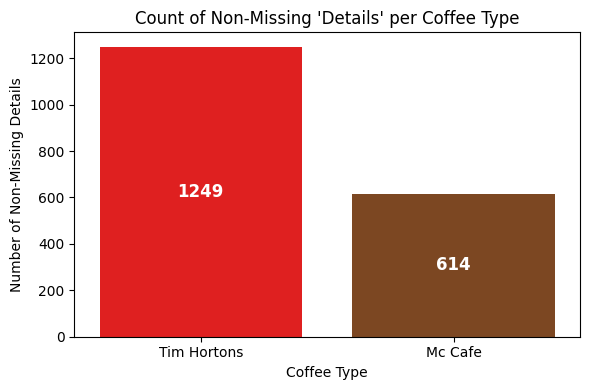

In [14]:
# Count of final review removing missing values
df_vf = pd.DataFrame(reviews)

non_missing_count = df['Details'].notna() & (df['Details'].str.strip() != '')
count = non_missing_count.sum()

counts_per_type = df_vf['Type'].value_counts().reset_index()
counts_per_type.columns = ['Type', 'Non_Missing_Count']

plt.figure(figsize=(6, 4))
ax = sns.barplot(data=counts_per_type, x='Type', y='Non_Missing_Count', hue='Type', palette=custom_palette, legend=False)

for container in ax.containers:
    ax.bar_label(container, label_type='center', color='white', fontsize=12, weight='bold')

plt.title("Count of Non-Missing 'Details' per Coffee Type")
plt.ylabel('Number of Non-Missing Details')
plt.xlabel('Coffee Type')
plt.tight_layout()
plt.show()

## **Text mining**

**Create the tokenizer**

In [15]:
""" Create the tokenizer to obtain a bag of words that were standardized by converting them to lowercase.
The list was filtered by eliminating common English stop words and specific terms, to finally get meaningful words."""

def tokenize(text):
    if not isinstance(text, str):
        return []

    lowercase_text = text.lower()
    tokens = re.findall(r'\b\w+\b', lowercase_text)

    #removing stop words according to the topic
    custom_stopwords = ENGLISH_STOP_WORDS.union({'t', 's', 'k', 'like', 'tim', 'hortons', 'horton', 'review', 'buy', 'just', 'product', 'coffee'})

    clean_tokens = [t for t in tokens if t not in custom_stopwords and len(t) > 2]

    return clean_tokens

In [16]:
# Apply tokenizer to the list of reviews and store them in a new single list
all_tokens = []

for review in reviews:
    if review.get("Details"):
        tokens = tokenize(review["Details"])
        all_tokens.extend(tokens)

all_tokens

['favourite',
 'home',
 'pleased',
 'able',
 'having',
 'add',
 'creamers',
 'sweeteners',
 'recommend',
 'keurig',
 'brewer',
 'love',
 'mccaf',
 'medium',
 'dark',
 'roast',
 'easier',
 'make',
 'fresh',
 'cup',
 'morning',
 'glad',
 'ordered',
 'lots',
 'keurig',
 'pods',
 'hand',
 'don',
 'run',
 'used',
 'pods',
 'recyclable',
 'yum',
 'love',
 'rich',
 'robust',
 'good',
 'bolder',
 'regular',
 'mccafe',
 'better',
 'darker',
 'roast',
 'coffees',
 'tasted',
 'perfect',
 'everytime',
 'tastes',
 'expected',
 'restaurants',
 'choose',
 'mcdonald',
 'mccafe',
 'pods',
 'taste',
 'mcdonalds',
 'bitter',
 'suggest',
 'way',
 'alter',
 'taste',
 'tried',
 'using',
 'water',
 'nice',
 'smooth',
 'taste',
 'right',
 'aroma',
 'tastes',
 'mcdonald',
 'bitter',
 'taste',
 'taste',
 'right',
 'blend',
 'definitely',
 'recommend',
 'brand',
 'friends',
 'make',
 'number',
 'favourite',
 'reach',
 'long',
 'day',
 'better',
 'great',
 'cup',
 'mccafe',
 'morning',
 'keurig',
 'terrible',
 'c

In [17]:
# Count the number of tokens in the list
word_count = len(all_tokens)
print(word_count)

25090


**TF Vectorization**

In [18]:
# Identify unique tokens and the number of times they appear in the document
def vectorize_tf(tokens):
    tf = {}
    for token in tokens:
        if token in tf:
            tf[token] += 1
        else:
            tf[token] = 1
    return tf

**Calculating IDF**

In [19]:
# Measure of how unique a word is across all documents in the corpus

N = len(reviews) # total number of documents

doc_freq = {} # document frequency for each word
for review in reviews:
  if not review['Details']:
    continue # some reviews do not have any content, skip these
  doc = tokenize(review['Details'])
  unique_tokens = set(doc) # only count once per document
  for token in unique_tokens:
      doc_freq[token] = doc_freq.get(token, 0) + 1

idf_dict = {}
for token, df in doc_freq.items():
    idf_dict[token] = log(N / df)

In [20]:
idf_dict

{'pleased': 5.332718793265369,
 'able': 3.6587423596936977,
 'favourite': 3.7457537366833273,
 'sweeteners': 7.529943370601589,
 'recommend': 2.2316260040535516,
 'having': 3.3555561007059516,
 'add': 3.67979576889153,
 'home': 2.2316260040535516,
 'brewer': 5.584033221546275,
 'keurig': 2.417955582245045,
 'creamers': 5.332718793265369,
 'ordered': 4.5342110970475975,
 'morning': 2.2569438120378416,
 'fresh': 3.310435665425482,
 'hand': 5.332718793265369,
 'glad': 4.394449154672439,
 'pods': 2.499505449209153,
 'dark': 3.1111027628049905,
 'run': 4.438900917243273,
 'used': 3.504591679866439,
 'cup': 1.7430459892348809,
 'lots': 6.143649009481698,
 'love': 1.3772106758974842,
 'roast': 2.461039168381357,
 'medium': 2.9973438774483325,
 'easier': 4.585504391435148,
 'recyclable': 3.974595309112175,
 'don': 3.0081547935525483,
 'make': 2.624668592163159,
 'mccaf': 5.584033221546275,
 'yum': 5.584033221546275,
 'robust': 5.045036720813588,
 'good': 1.5950491749820008,
 'rich': 2.70162963

In [21]:
# Sort tokens by IDF score
sorted_idf = sorted(idf_dict.items(), key=lambda x: x[1])

# Create DataFrames
common_words = pd.DataFrame(sorted_idf[:20], columns=["Word", "IDF Score"])
unique_words = pd.DataFrame(sorted_idf[-5:], columns=["Word", "IDF Score"])

# Style the DataFrames
styled_common = common_words.style.background_gradient(cmap='Greens_r').set_caption("Top 20 Most Common Words (Lowest IDF)")
styled_unique = unique_words.style.background_gradient(cmap='Oranges_r').set_caption("Top 5 Most Unique Words (Highest IDF)")

# Display results
display(styled_common)
display(styled_unique)

,Word,IDF Score
0,great,1.372964
1,love,1.377211
2,taste,1.411846
3,cups,1.558682
4,good,1.595049
5,cup,1.743046
6,definitely,1.816211
7,flavor,1.927825
8,smooth,2.150046
9,recommend,2.231626


,Word,IDF Score
0,recommade,7.529943
1,fortement,7.529943
2,üòæ,7.529943
3,catching,7.529943
4,beginning,7.529943


**TF-IDF Vectorization**

In [22]:
# Identify how unique the word is when compared to the rest of the documents in the collection
def vectorize_tf_idf(tokens):
    tf = {}
    for token in tokens:
        if token in tf:
            tf[token] += 1
        else:
            tf[token] = 1

    tf_idf = {}
    for token, doc_freq in tf.items():
        if token in idf_dict:
            tf_idf[token] = doc_freq * idf_dict[token]

    return tf_idf

tf_idf = vectorize_tf_idf(all_tokens)
tf_idf

{'favourite': 168.55891815074972,
 'home': 477.56796486746003,
 'pleased': 47.99446913938832,
 'able': 175.6196332652975,
 'having': 231.53337094871065,
 'add': 176.63019690679343,
 'creamers': 47.99446913938832,
 'sweeteners': 7.529943370601589,
 'recommend': 448.5568268147639,
 'keurig': 469.08338295553875,
 'brewer': 39.088232550823925,
 'love': 771.2379785025912,
 'mccaf': 39.088232550823925,
 'medium': 305.7290754997299,
 'dark': 304.8880707548891,
 'roast': 487.2857553395086,
 'easier': 87.1245834372678,
 'make': 372.7029400871686,
 'fresh': 231.73049657978373,
 'cup': 678.0448898123686,
 'morning': 473.9582005279467,
 'glad': 101.0723305574661,
 'ordered': 108.82106632914234,
 'lots': 24.574596037926792,
 'pods': 484.9040571465757,
 'hand': 47.99446913938832,
 'don': 294.79916976814974,
 'run': 102.09472109659528,
 'used': 199.76172575238704,
 'recyclable': 162.95840767359917,
 'yum': 39.088232550823925,
 'rich': 348.51022269560804,
 'robust': 60.540440649763056,
 'good': 690.65

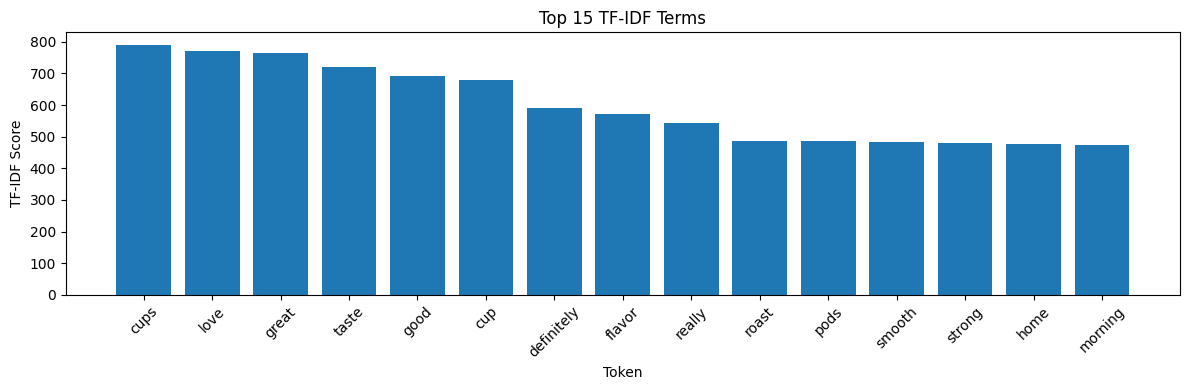

In [23]:
# Chart of results TF-IDF
sorted_tf_idf = sorted(tf_idf.items(), key=lambda item: item[1], reverse=True)
tf_idf_df = pd.DataFrame(sorted_tf_idf, columns=['Token', 'TF-IDF Score'])

top_n = 15
top_tf_idf = tf_idf_df.head(top_n)

plt.figure(figsize=(12, 4))
plt.bar(top_tf_idf['Token'], top_tf_idf['TF-IDF Score'])
plt.xticks(rotation=45)
plt.title(f"Top {top_n} TF-IDF Terms")
plt.xlabel("Token")
plt.ylabel("TF-IDF Score")
plt.tight_layout()
plt.show()

## **Sentiment Analysis**

**Download the lexicon**

In [24]:
# Download Lexicon provided from in BAN200 class
!wget https://raw.githubusercontent.com/wd13ca/BAN200-Summer-2025/refs/heads/main/lexicon.txt

--2025-08-05 23:41:19--  https://raw.githubusercontent.com/wd13ca/BAN200-Summer-2025/refs/heads/main/lexicon.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105077 (103K) [text/plain]
Saving to: ‘lexicon.txt’

lexicon.txt         100%[===================>] 102.61K  --.-KB/s    in 0.02s   

2025-08-05 23:41:19 (5.01 MB/s) - ‘lexicon.txt’ saved [105077/105077]



In [25]:
# Read the sentiment lexicon file
lexicon = {}

with open("lexicon.txt", "r") as file:
    for line in file:
        word, score = line.strip().split('\t')
        lexicon[word] = float(score)

lexicon

{"---'-;-{@": 2.3,
 '--<--<@': 2.2,
 ',-:': 1.2,
 ';-)': 1.0,
 ';-]': 0.7,
 ';-*': 2.2,
 ';)': 0.9,
 ';]': 0.6,
 ';^)': 1.4,
 ';d': 0.8,
 ';D': 0.8,
 ':-,': 1.1,
 ':-.': -0.9,
 ':-(': -1.5,
 ':-)': 1.3,
 ':-))': 2.8,
 ':-[': -1.6,
 ':-*': 1.7,
 ':-/': -1.2,
 ':-\\': -0.9,
 ':-&': -0.5,
 ':-###..': -2.5,
 ':-<': -1.5,
 ':-|': -0.7,
 ':-||': -2.5,
 ':-c': -1.3,
 ':-d': 2.3,
 ':-D': 2.3,
 ':-o': 0.1,
 ':-p': 1.5,
 ':-Þ': 0.9,
 ':?)': 1.3,
 ':?c': -1.6,
 ":'-(": -2.4,
 ":'-)": 2.7,
 ":'(": -2.2,
 ":')": 2.3,
 ':(': -1.9,
 ':)': 2.0,
 ':[': -2.0,
 ':]': 2.2,
 ':{': -1.9,
 ':}': 2.1,
 ':@': -2.5,
 ':*': 2.5,
 ':/': -1.4,
 ':\\': -1.3,
 ':&': -0.6,
 ':###..': -2.4,
 ':^)': 2.1,
 ':^*': 2.6,
 ':^/': -1.2,
 ':^\\': -1.0,
 ':^|': -1.0,
 ':<': -2.1,
 ':>': 2.1,
 ':|': -0.4,
 ':$': -0.2,
 ':3': 2.3,
 ':c': -2.1,
 ':c)': 2.0,
 ':d': 2.3,
 ':D': 2.3,
 ':l': -1.7,
 ':o': -0.4,
 ':o)': 2.1,
 ':o/': -1.4,
 ':o\\': -1.1,
 ':o|': -0.6,
 ':p': 1.0,
 ':P': 1.4,
 ':s': -1.2,
 ':Þ': 1.1,
 '.-:': -1.2,
 '..##

In [26]:
# Lexicon length
print(len(lexicon))

7506


**Sparse dot product**

In [27]:
# Function to calculate the dot product between two sparse vectors. Used to calculate sentiment score
def sparse_dot_product(vec1, vec2):
     return sum(vec1[token] * vec2[token] for token in vec1 if token in vec2)

**Sentiment score**

In [28]:
# Calculate sentiment score using TF calculation and sentiment score from the lexicon

results = []

for review in reviews:
    details = review.get('Details', '')
    if not isinstance(details, str) or not details.strip():
        continue  # skip if Details is empty or not a string

    tokens = tokenize(details)

    if not tokens:
        continue  # skip reviews that result in no tokens

    tf = vectorize_tf(tokens)
    sentiment_score = sparse_dot_product(tf, lexicon)
    star_rating = review['Score']
    results.append((round(sentiment_score, 2), star_rating))

In [29]:
results

[(3.4, 5),
 (10.5, 5),
 (9.1, 5),
 (3.1, 5),
 (2.7, 5),
 (-1.8, 4),
 (10.7, 4),
 (-0.7, 2),
 (0, 1),
 (2.7, 5),
 (5.3, 5),
 (0, 5),
 (2.7, 5),
 (5.7, 4),
 (5.0, 5),
 (6.2, 5),
 (5.0, 5),
 (-2.1, 1),
 (1.9, 5),
 (5.0, 5),
 (7.7, 5),
 (8.8, 5),
 (-6.3, 1),
 (4.6, 5),
 (1.6, 5),
 (5.9, 5),
 (3.1, 5),
 (8.4, 5),
 (2.7, 5),
 (0, 5),
 (5.8, 5),
 (-4.1, 1),
 (1.0, 5),
 (1.9, 5),
 (2.7, 5),
 (3.1, 5),
 (7.3, 5),
 (5.8, 5),
 (1.9, 5),
 (2.7, 5),
 (0, 5),
 (-4.1, 1),
 (8.4, 5),
 (4.8, 5),
 (5.0, 5),
 (2.2, 5),
 (7.7, 3),
 (7.2, 5),
 (8.9, 5),
 (10.4, 5),
 (9.3, 5),
 (0.5, 4),
 (26.6, 5),
 (-1.0, 3),
 (3.1, 5),
 (6.3, 5),
 (3.8, 5),
 (1.9, 5),
 (2.6, 4),
 (2.8, 5),
 (5.0, 5),
 (3.2, 5),
 (4.2, 5),
 (2.8, 5),
 (5.0, 5),
 (6.3, 5),
 (3.1, 5),
 (3.2, 5),
 (1.9, 5),
 (3.8, 5),
 (3.1, 5),
 (2.0, 5),
 (3.1, 5),
 (3.1, 5),
 (3.2, 5),
 (3.2, 5),
 (12.6, 5),
 (17.4, 5),
 (15.8, 5),
 (30.4, 5),
 (20.4, 5),
 (15.6, 4),
 (4.7, 5),
 (13.9, 4),
 (11.6, 4),
 (7.4, 5),
 (5.4, 4),
 (10.1, 5),
 (10.6, 5),
 (14.1, 

In [30]:
# Add sentiment score into the review dicts
for i, (score, _) in enumerate(results):
    reviews[i]['SentimentScore'] = score

df_reviews = pd.DataFrame(reviews)

positive_df = df_reviews[df_reviews['SentimentScore'] > 0]
negative_df = df_reviews[df_reviews['SentimentScore'] < 0]

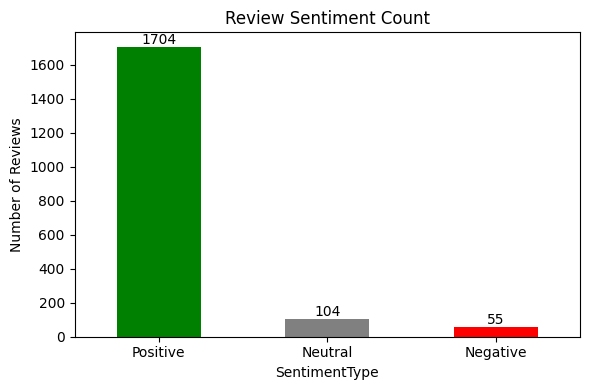

In [31]:
#Plot positive and negative sentiment
df_reviews['SentimentType'] = df_reviews['SentimentScore'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

# Plot
sentiment_counts = df_reviews['SentimentType'].value_counts()

plt.figure(figsize=(6, 4))
ax = sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'])

# Add value labels on top of each bar
for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10)

plt.title('Review Sentiment Count')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

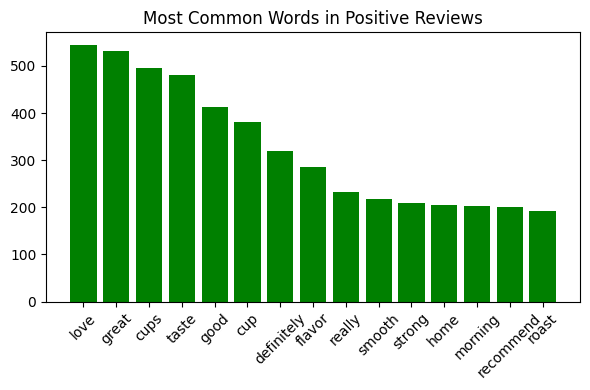

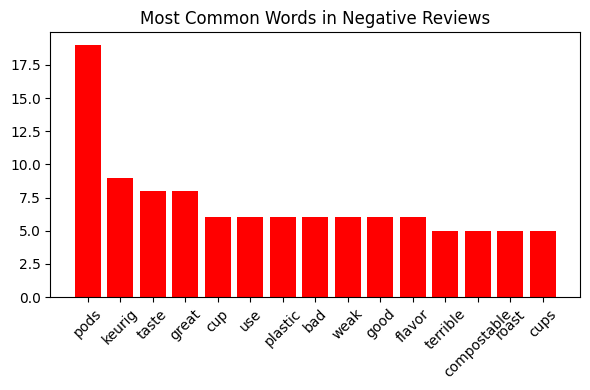

In [32]:
# Positive and Negative words
positive_tokens = []
negative_tokens = []

for review in reviews:
    score = review.get('SentimentScore', 0)
    text = review.get('Details', '')
    tokens = tokenize(text)
    if score > 0:
        positive_tokens.extend(tokens)
    elif score < 0:
        negative_tokens.extend(tokens)

# Count and get most common
positive_common = Counter(positive_tokens).most_common(15)
negative_common = Counter(negative_tokens).most_common(15)

# Plot Positive
pos_words, pos_counts = zip(*positive_common)
plt.figure(figsize=(6,4))
plt.bar(pos_words, pos_counts, color='green')
plt.title('Most Common Words in Positive Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Negative
neg_words, neg_counts = zip(*negative_common)
plt.figure(figsize=(6,4))
plt.bar(neg_words, neg_counts, color='red')
plt.title('Most Common Words in Negative Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Evalutation**

In [33]:
# Store sentiment scores grouped by star rating (excluding zero scores)
scores_by_rating = {}

for sentiment_score, star_rating in results:
    if sentiment_score == 0:
        continue  # skip neutral (zero) sentiment scores
    if star_rating not in scores_by_rating:
        scores_by_rating[star_rating] = []
    scores_by_rating[star_rating].append(sentiment_score)

# Calculate and print average sentiment and review count per rating
print("Average Sentiment Score by Star Rating (non-zero only):\n")
for rating in sorted(scores_by_rating):
    scores = scores_by_rating[rating]
    avg_score = sum(scores) / len(scores)
    count = len(scores)
    print(f"{rating} stars: {avg_score:.2f} (n = {count} reviews)")


Average Sentiment Score by Star Rating (non-zero only):

1 stars: 1.88 (n = 59 reviews)
2 stars: 3.27 (n = 24 reviews)
3 stars: 4.85 (n = 89 reviews)
4 stars: 7.99 (n = 362 reviews)
5 stars: 7.41 (n = 1225 reviews)


/tmp/ipython-input-2704439268.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('plasma')


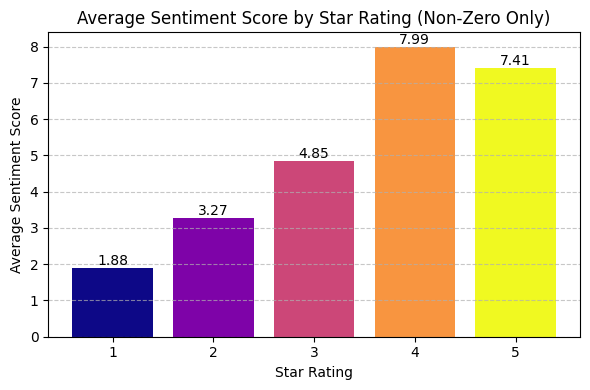

In [34]:
# Explore results
ratings = sorted(scores_by_rating.keys())
avg_scores = [sum(scores_by_rating[r]) / len(scores_by_rating[r]) for r in ratings]
review_counts = [len(scores_by_rating[r]) for r in ratings]

cmap = get_cmap('plasma')
colors = [cmap(i / (len(ratings) - 1)) for i in range(len(ratings))]

plt.figure(figsize=(6, 4))
bars = plt.bar(ratings, avg_scores, color=colors)

plt.xlabel('Star Rating')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score by Star Rating (Non-Zero Only)')
plt.xticks(ratings)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar, score in zip(bars, avg_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f"{score:.2f}", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

## **LDA**

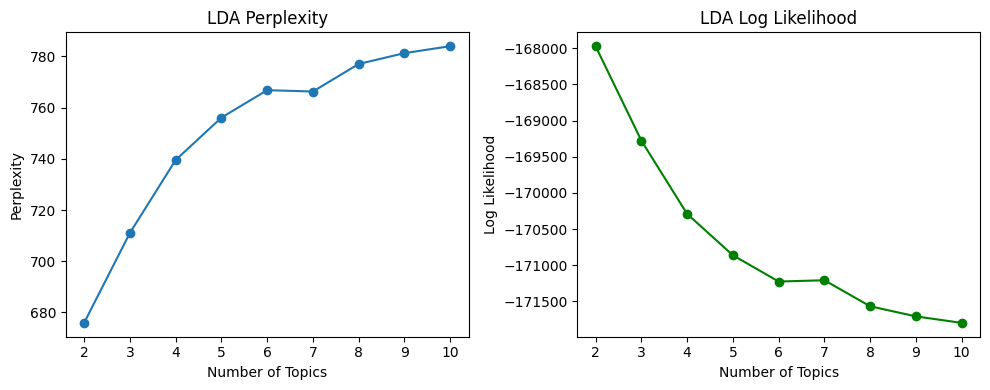

In [35]:
custom_stopwords = list(ENGLISH_STOP_WORDS.union({'t', 's', 'k', 'like', 'tim', 'hortons', 'horton', 'review', 'buy', 'just', 'mcdonalds', 'mcdonald'}))
# Create the document-term matrix
count_vectorizer = CountVectorizer(stop_words=custom_stopwords, max_df=0.5)
doc_term_matrix = count_vectorizer.fit_transform(df_vf["Details"].dropna())

# Try different numbers of topics
topic_range = range(2, 11)
perplexities = []
log_likelihoods = []

for n_topics in topic_range:
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(doc_term_matrix)
    perplexities.append(lda.perplexity(doc_term_matrix))
    log_likelihoods.append(lda.score(doc_term_matrix))  # Higher is better

# Plotting perplexity
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(topic_range, perplexities, marker='o')
plt.title('LDA Perplexity')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')

# Plotting log-likelihood
plt.subplot(1, 2, 2)
plt.plot(topic_range, log_likelihoods, marker='o', color='green')
plt.title('LDA Log Likelihood')
plt.xlabel('Number of Topics')
plt.ylabel('Log Likelihood')

plt.tight_layout()
plt.show()

In [36]:
# Create the dataset to run LDA
lda_reviews = df_vf["Details"].dropna().tolist()

# Apply LDA model with three topics
lda_model = LatentDirichletAllocation(n_components=2, random_state=42)
doc_topic_dist = lda_model.fit_transform(doc_term_matrix)

# Extract top 5 words per topic
def get_top_words(model, feature_names, n_top_words=5):
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words[f"Topic {topic_idx + 1}"] = top_features
    return pd.DataFrame(top_words)

feature_names = count_vectorizer.get_feature_names_out()
top_words_df = get_top_words(lda_model, feature_names)

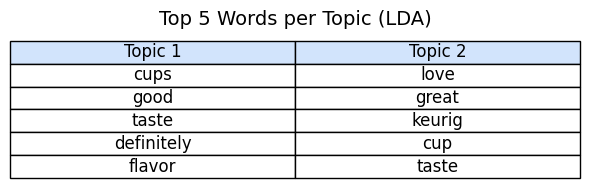

In [37]:
# Create the table
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')

table = ax.table(
    cellText=top_words_df.values,
    colLabels=top_words_df.columns,
    loc='center',
    cellLoc='center',
    colColours=['#d2e4fc'] * len(top_words_df.columns)
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

plt.title("Top 5 Words per Topic (LDA)", fontsize=14, pad=10)
plt.tight_layout()
plt.show()

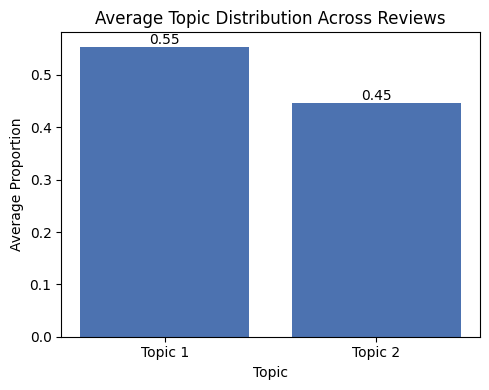

In [38]:
# Show the average topic distribution across all the dataset
avg_topic_dist = doc_topic_dist.mean(axis=0)
topic_labels = [f"Topic {i+1}" for i in range(len(avg_topic_dist))]
avg_topic_df = pd.DataFrame({"Topic": topic_labels,"Average Proportion": avg_topic_dist})

plt.figure(figsize=(5, 4))
bars = plt.bar(topic_labels, avg_topic_dist, color="#4C72B0")

# Annotate each bar with its average value
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.2f}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title("Average Topic Distribution Across Reviews")
plt.xlabel("Topic")
plt.ylabel("Average Proportion")
plt.tight_layout()
plt.show()

## **Document clustering: K-Means to all reviews**

In [39]:
# Create function for cosine similarity
def cosine_similarity(vec1, vec2):
    dot = sparse_dot_product(vec1, vec2)
    mag1 = sqrt(sparse_dot_product(vec1, vec1))
    mag2 = sqrt(sparse_dot_product(vec2, vec2))
    if mag1 == 0 or mag2 == 0:
        return 0.0
    return dot / (mag1 * mag2)

In [40]:
# Create function to compute the average of a list of sparse vectors
def mean_vector(vectors):
    summed = {}
    for vec in vectors:
        for key, value in vec.items():
            summed[key] = summed.get(key, 0) + value
    count = len(vectors)
    return {k: v / count for k, v in summed.items()}

In [41]:
# Create a new review dictionary that contains TF-IDF
for i, review in enumerate(reviews):
		tf_idf = vectorize_tf_idf(tokenize(review['Details']))
		reviews[i]['tf-idf'] = tf_idf

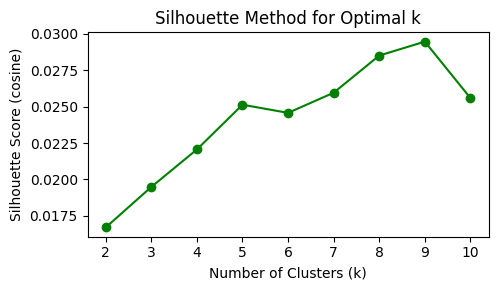

In [42]:
# Identify number of clusters with silhouette scores

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_vf['Details'].astype(str))

silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(tfidf_matrix)
    score = silhouette_score(tfidf_matrix, labels, metric='cosine')
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(5, 3))
plt.plot(k_range, silhouette_scores, 'go-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score (cosine)")
plt.title("Silhouette Method for Optimal k")
plt.tight_layout()
plt.show()

In [43]:
# Apply K-means

# 1: Initialize centroids according to silhouette scores
k = 5
centroids = random.sample([r['tf-idf'] for r in reviews], k)

for iteration in range(100):
    print(f"Iteration {iteration+1}")

# 2: Assign documents to closest centroid
    clusters = [[] for _ in range(k)]
    for doc in reviews:
        similarities = [cosine_similarity(doc['tf-idf'], centroid) for centroid in centroids]
        best_cluster = similarities.index(max(similarities))
        clusters[best_cluster].append(doc)

# 3: Update centroids by averaging each cluster
    new_centroids = [mean_vector([review['tf-idf'] for review in cluster]) if cluster else centroids[i] for i, cluster in enumerate(clusters)]

# 4: Check for convergence (no change in centroids)
    if new_centroids == centroids:
        print("Converged.")
        break
    centroids = new_centroids

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Converged.


In [44]:
# Print number of reviews for each cluster
for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {len(cluster)} reviews")

Cluster 0: 383 reviews
Cluster 1: 241 reviews
Cluster 2: 549 reviews
Cluster 3: 348 reviews
Cluster 4: 342 reviews


In [45]:
# Print the first 10 reviews from each cluster
for i, cluster in enumerate(clusters):
    print(f"\n=== Cluster {i} ===")
    for review in cluster[:10]:
        print("-", review['Details'][:200])


=== Cluster 0 ===
- Keurig is terrible product! Have had 3 of the carafe's in the last year as they break easily!!! Very poorly quality manufacturing! This company would do the public a service if they just folded and we
- J'ai passé ma commande le 1er décembre, et nous sommes aujourd'hui le 17 et je ne l'ai pas encore reçue. Quand j'ai appelé le service client, ils m'ont dit peut-être la semaine prochaine, le 22 décemb
- Terrible leaves coffee grounds in cup
- It helps wake me up like coffee should! 1 cup 1 pod
- Cant het enough of this coffee
- Terrible product. Extremely wasteful packaging. Should be banned. Learn to use a spoon!
- Cant het enough of this coffee
- Terrible product. Extremely wasteful packaging. Should be banned. Learn to use a spoon!
- I just purchased a coffee machine with several cup sizes. I don't know what the optimal or recommended size is for this coffee. So it may take a while to determine how best to enjoy this coffee
- I like brewed coffee and my partner p

In [46]:
# Calculate the average star rating for each cluster
for i, cluster in enumerate(clusters):
    scores = [review['Score'] for review in cluster]
    avg_score = sum(scores) / len(scores) if scores else 0
    print(f"Cluster {i} average rating: {avg_score:.2f}")

Cluster 0 average rating: 4.22
Cluster 1 average rating: 4.37
Cluster 2 average rating: 4.65
Cluster 3 average rating: 4.59
Cluster 4 average rating: 4.61


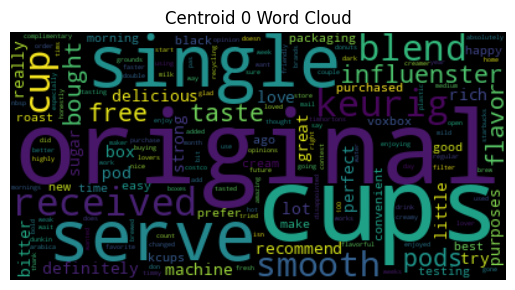

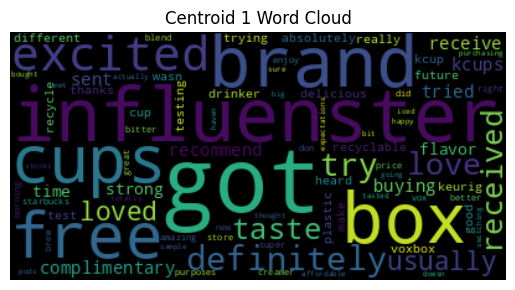

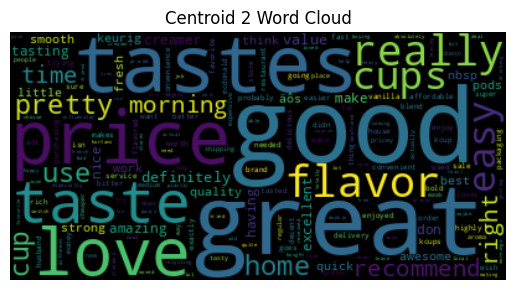

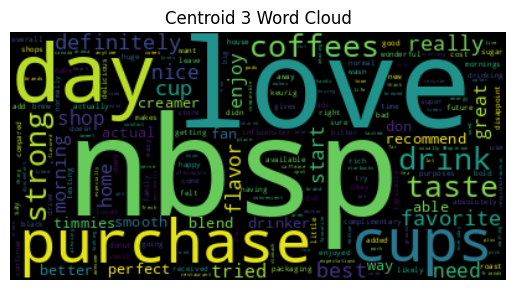

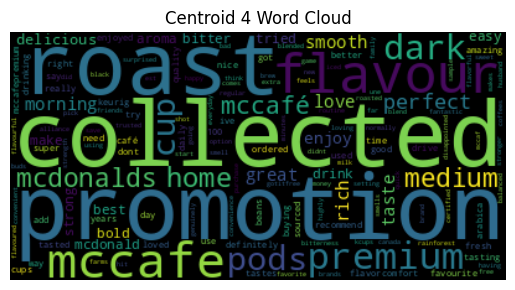

In [47]:
# Print word cloud for each cluster
for i, centroid in enumerate(centroids):
    wc = WordCloud(width=400, height=200)
    wc.generate_from_frequencies(centroid)
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Centroid {i} Word Cloud")
    plt.show()

In [48]:
# New sparse dot function that calculates the dot product and prints words which are contributing to that calculation
def sparse_dot_product(vec1, vec2):
    total = 0
    print("Words contributing to dot product:")
    for token in vec1:
        if token in vec2:
            contribution = vec1[token] * vec2[token]
            print(f"  '{token}': {vec1[token]} * {vec2[token]} = {contribution}")
            total += contribution
    return total

In [49]:
sparse_dot_product(tf, lexicon)

Words contributing to dot product:
  'love': 1 * 3.2 = 3.2
  'strong': 1 * 2.3 = 2.3
  'disappoints': 1 * -1.6 = -1.6


3.9

## **N-grams**

In [50]:
# Function to extract top n-grams (bigrams/trigrams)
custom_stopwords = list(ENGLISH_STOP_WORDS.union({'t', 's', 'k', 'like', 'tim', 'hortons', 'horton', 'review', 'buy', 'just', 'mcdonalds', 'mcdonald'}))
def get_top_ngrams(corpus, ngram_range=(2,2), n=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=custom_stopwords, max_df=0.5, min_df=2)
    X = vectorizer.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    ngrams_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)
    return ngrams_freq[:n]

# Apply to the reviews
top_bigrams = get_top_ngrams(df_vf['Details'], ngram_range=(2, 2), n=10)
top_trigrams = get_top_ngrams(df_vf['Details'], ngram_range=(3, 3), n=10)

# Create DataFrames for bigrams and trigrams
bigrams_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])
trigrams_df = pd.DataFrame(top_trigrams, columns=['Trigram', 'Frequency'])

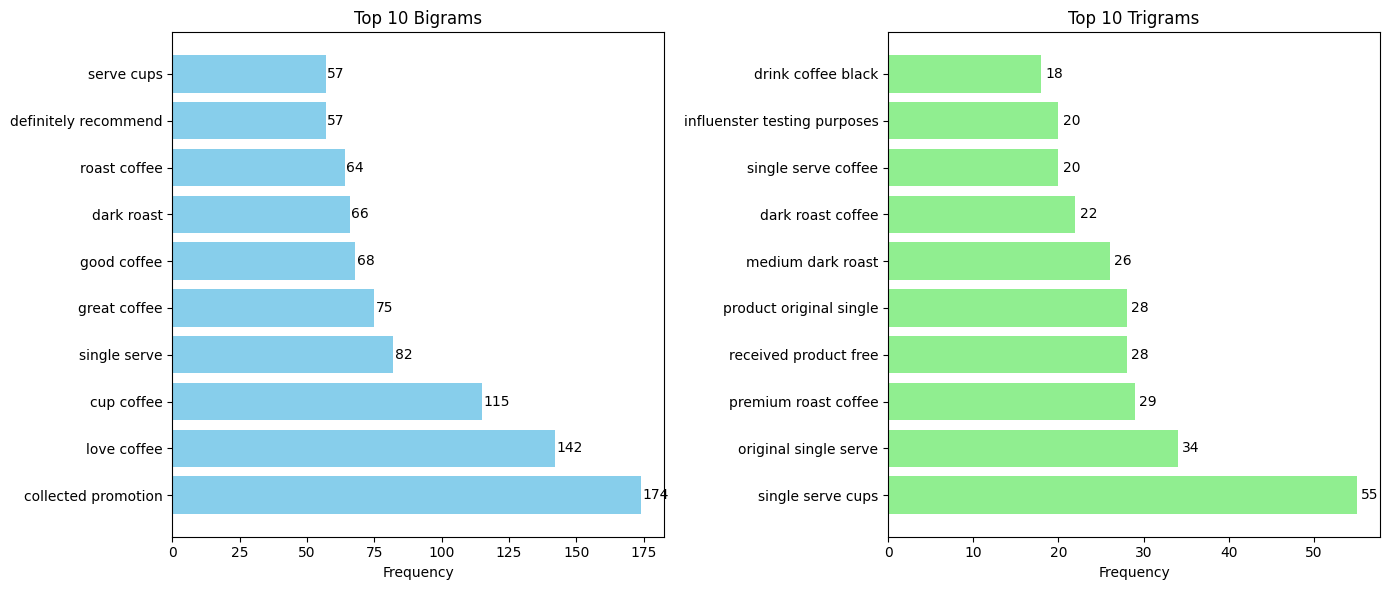

In [51]:
# Create side-by-side horizontal bar charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

bars1 = axes[0].barh(bigrams_df['Bigram'], bigrams_df['Frequency'], color='skyblue')
axes[0].set_title('Top 10 Bigrams')
axes[0].set_xlabel('Frequency')

for bar in bars1:
    width = bar.get_width()
    axes[0].text(width + 0.5, bar.get_y() + bar.get_height()/2, str(int(width)), va='center')

bars2 = axes[1].barh(trigrams_df['Trigram'], trigrams_df['Frequency'], color='lightgreen')
axes[1].set_title('Top 10 Trigrams')
axes[1].set_xlabel('Frequency')

for bar in bars2:
    width = bar.get_width()
    axes[1].text(width + 0.5, bar.get_y() + bar.get_height()/2, str(int(width)), va='center')

plt.tight_layout()
plt.show()

In [52]:
# Function to extract n-grams by sentiment
def extract_ngrams_by_sentiment(df_subset, ngram_range=(2, 2), n=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=custom_stopwords, max_df=0.5, min_df=2)
    X = vectorizer.fit_transform(df_subset)
    sum_words = X.sum(axis=0)
    ngrams_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)
    return pd.DataFrame(ngrams_freq[:n], columns=['N-gram', 'Frequency'])

# Split positive and negative reviews
positive_reviews = df_reviews[df_reviews['SentimentScore'] > 0]['Details']
negative_reviews = df_reviews[df_reviews['SentimentScore'] < 0]['Details']

# Get bigrams and trigrams
pos_bigrams_df = extract_ngrams_by_sentiment(positive_reviews, ngram_range=(2, 2))
neg_bigrams_df = extract_ngrams_by_sentiment(negative_reviews, ngram_range=(2, 2))
pos_trigrams_df = extract_ngrams_by_sentiment(positive_reviews, ngram_range=(3, 3))
neg_trigrams_df = extract_ngrams_by_sentiment(negative_reviews, ngram_range=(3, 3))

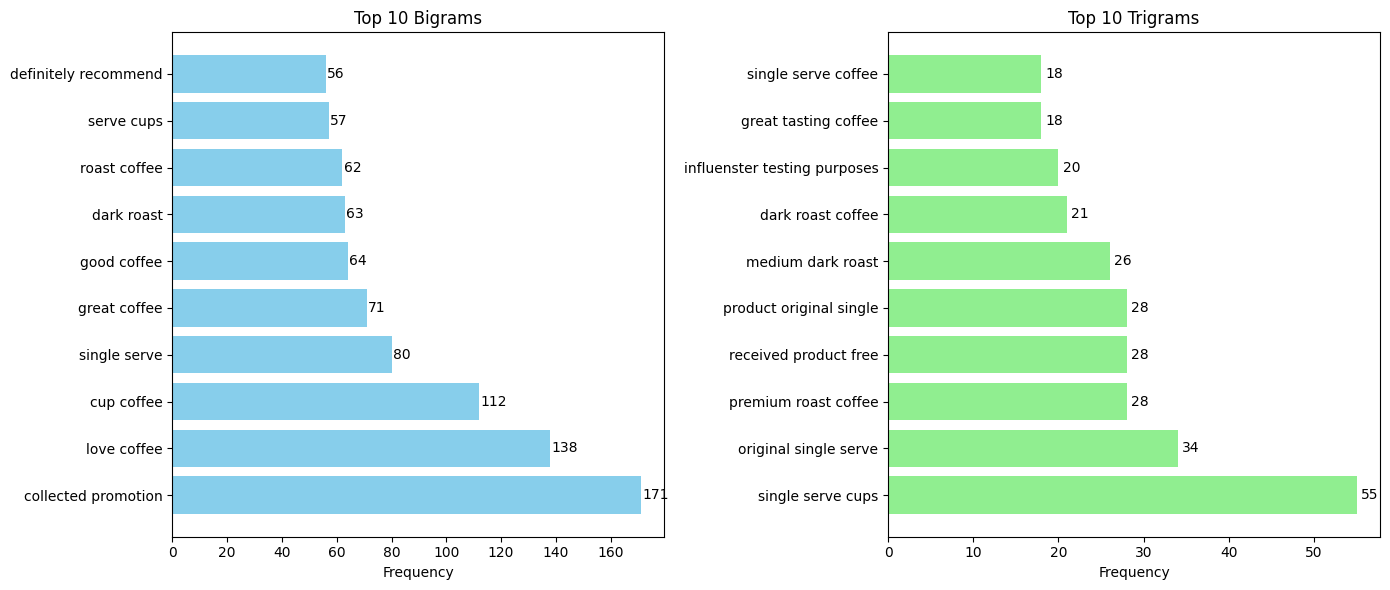

In [53]:
# Create side-by-side horizontal bar charts for positive reviews
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

bars1 = axes[0].barh(pos_bigrams_df['N-gram'], pos_bigrams_df['Frequency'], color='skyblue')
axes[0].set_title('Top 10 Bigrams')
axes[0].set_xlabel('Frequency')

for bar in bars1:
    width = bar.get_width()
    axes[0].text(width + 0.5, bar.get_y() + bar.get_height()/2, str(int(width)), va='center')

bars2 = axes[1].barh(pos_trigrams_df['N-gram'], pos_trigrams_df['Frequency'], color='lightgreen')
axes[1].set_title('Top 10 Trigrams')
axes[1].set_xlabel('Frequency')

for bar in bars2:
    width = bar.get_width()
    axes[1].text(width + 0.5, bar.get_y() + bar.get_height()/2, str(int(width)), va='center')

plt.tight_layout()
plt.show()

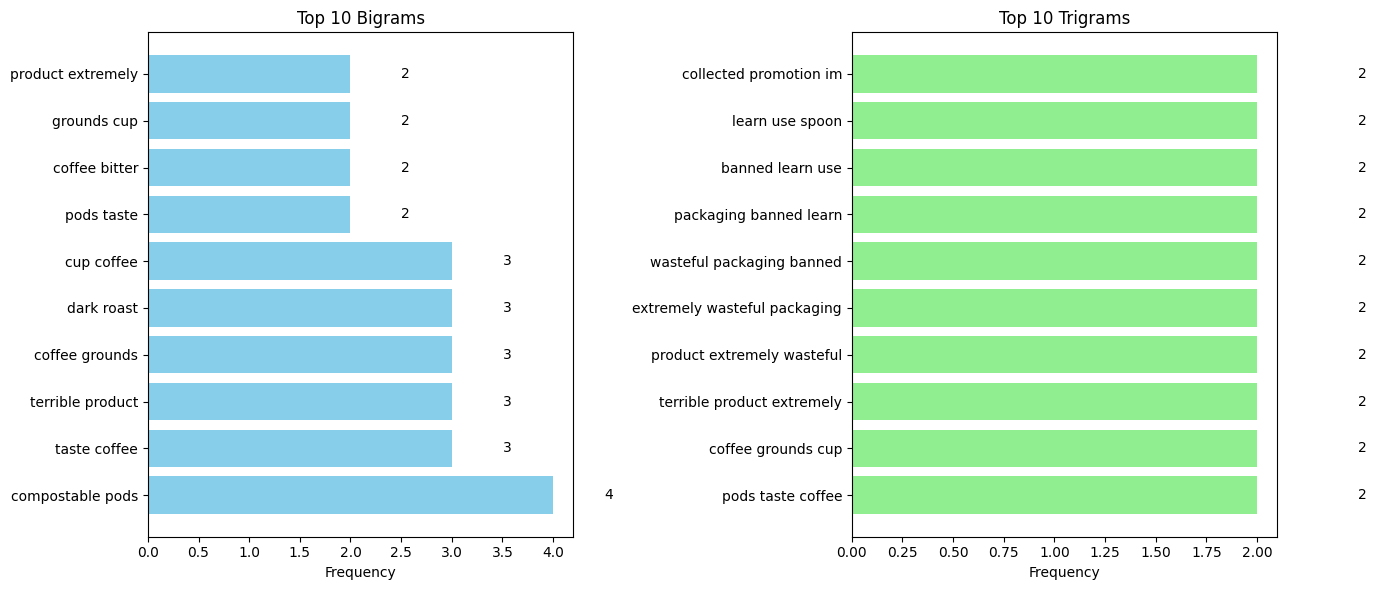

In [54]:
# Create side-by-side horizontal bar charts for negative reviews
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

bars1 = axes[0].barh(neg_bigrams_df['N-gram'], neg_bigrams_df['Frequency'], color='skyblue')
axes[0].set_title('Top 10 Bigrams')
axes[0].set_xlabel('Frequency')

for bar in bars1:
    width = bar.get_width()
    axes[0].text(width + 0.5, bar.get_y() + bar.get_height()/2, str(int(width)), va='center')

bars2 = axes[1].barh(neg_trigrams_df['N-gram'], neg_trigrams_df['Frequency'], color='lightgreen')
axes[1].set_title('Top 10 Trigrams')
axes[1].set_xlabel('Frequency')

for bar in bars2:
    width = bar.get_width()
    axes[1].text(width + 0.5, bar.get_y() + bar.get_height()/2, str(int(width)), va='center')

plt.tight_layout()
plt.show()